<a href="https://colab.research.google.com/github/FabriceBeaumont/1-MA-INF_2314_IPSA_Repo/blob/main/Code/Exercise6/SolutionsOfSheet6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IPSA 2021 - Exercise 6 - Interpolation and image warping

## 0 - Practical Advice

In [62]:
import imageio 
import numpy as np
import numpy.random as rnd
import numpy.linalg as la
from numpy import exp, sin, cos
import scipy.signal as sig

import scipy.ndimage as img
import scipy.interpolate as ipl
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 6]
import timeit, functools

In [4]:
def imageScaleRange(f, vmin=0, vmax=255):
    """Stretches the intensity values of a given image array f 
    such that they cover the whole range from 0 to 255"""
    return np.interp(f, (f.min(), f.max()), (vmin, vmax))

def imageRead(imgname, pilmode ='L', arrtype=float):
    """
    Read an image file into a numpy array

    imgname: str
        name of image file to be read
    pilmode: str
        for luminance / intesity images use ’L’
        for RGB color images use ’RGB’
    
    arrtype: numpy dtype
        use np.float, np.uint8, ...
    """
    return imageio.imread(imgname, pilmode=pilmode).astype(arrtype)

def imageWrite(arrF, imgname, arrtype=np.uint8):
    """
    Write a numpy array as an image file 
    the file type is inferred from the suffix of parameter imgname, e.g. ’.png’
    arrF: array_like
        array to be written
    imgname: str
        name of image file to be written
    arrtype: numpy dtype
        use np.uint8, ...
    """
    imageio.imwrite(imgname, arrF.astype(arrtype))

In [20]:
def writeFigure(fig, fname):
    fmt = fname.split('.')[-1]
    fig.savefig(fname, facecolor=fig.get_facecolor(), edgecolor='w',
                papertype='letter', format=fmt, transparent=False,
                bbox_inches='tight', pad_inches=0)

def plotFcts(x, fs,
             labs=None, lfs='x-small',
             xtcs=None, ytcs=None,
             lims=None, fname=None, title=None):

    # Initialize figure and axes.
    fig = plt.figure()
    axs = fig.add_subplot(211, facecolor='w')

    # Nicer way of showing coordinate axes.
    for pos in ['left','bottom']:
        axs.spines[pos].set_position('zero')
    for pos in ['right','top']:
        axs.spines[pos].set_visible(False)
        
    # Plot the function.
    for f in fs:
        axs.plot(x, f, '-', alpha=0.75)

    # Plot the legend.
    if labs is not None:
        axs.legend(labs, loc="upper right", fontsize=lfs,
                   facecolor='#e0e0e0', edgecolor='k', fancybox=False)

    if xtcs is not None: axs.set_xticks(xtcs)
    if ytcs is not None: axs.set_yticks(ytcs)
    
    if lims is not None:
        axs.set_xlim(lims[0], lims[1])
        axs.set_ylim(lims[2], lims[3])
        
    if title:
        plt.title(title)
        
        
    # Show figure on screen or write it to disc.
    plt.show() if fname is None else writeFigure(fig, fname)
    plt.close()

def plotShapeFct(Z, closed=True, lw=1, ms=2, mew=0, al=0.75, fname=None, title=None):
    # Initialize figure and axes.
    fig = plt.figure()
    axs = fig.add_subplot('111', facecolor='w')
    axs.set_aspect(aspect='equal')
    
    # Nicer way of showing coordinate axes.
    for pos in ['left','bottom']:
        axs.spines[pos].set_position('zero')
    for pos in ['right','top']:
        axs.spines[pos].set_visible(False)
        

    if closed:
        Z = np.hstack((Z, Z[0]))
        
    X = Z.real
    Y = Z.imag

    # Plot dottet or as line - depending on the 'closed'-flag.
    if closed:
        axs.plot(X, Y, '-', lw=lw, alpha=al)
    else:
        axs.plot(X, Y, 'o', ms=ms, mew=mew, alpha=al)

    xmin, xmax = min(-1, np.min(X)-1), np.max(X)+1
    ymin, ymax = min(-1, np.min(Y)-1), np.max(Y)+1
    
    axs.set_xlim(xmin, xmax)
    axs.set_ylim(ymin, ymax)

    if title:
        plt.title(title)

    # Show figure on screen or write it to disc.
    plt.show() if fname is None else writeFigure(fig, fname)
    plt.close()

    return fig


    
def plotFct(xdsc, ydsc, xcnt=None, ycnt=None,
            lw=1, ms=5, mew=0, al=0.75, title=None, fname=None):
    fig = plt.figure()
    axs = fig.add_subplot('211', facecolor='w')
    
    for pos in ['left','bottom']:
        axs.spines[pos].set_position('zero')
        axs.spines[pos].set_color('#a0a0a0')
    for pos in ['right','top']:
        axs.spines[pos].set_visible(False)

        
    if xcnt is not None and ycnt is not None:
        axs.plot(xcnt, ycnt, '-', lw=lw)
        
    #axs.vlines(xdsc, np.zeros_like(xdsc), ydsc, color='k', lw=lw)
    axs.plot(xdsc, ydsc, 'o', c='k', ms=ms, mew=mew)

    axs.set_xticks([])
    axs.set_yticks([])
    
    axs.set_xlim(-1.00, np.max(xdsc)+1.0)
    axs.set_ylim(-0.25, np.max(ydsc)+0.5)

    if title is not None:
        axs.set_title(title)

    # show figure on screen or write it to disc
    plt.show() if fname is None else writeFigure(fig, fname)
    plt.close()

In [21]:
def plotImagesAsRow(images, titles=None):
    # Display the images side by side.
    fig, axs = plt.subplots(1, len(images), figsize=(20,20))

    for i, image in enumerate(images):
        ax = axs[i]
        ax.imshow(image, cmap='gray') 
        if titles is not None: 
            ax.set_title(titles[i], fontsize=30)
        
        ax.set_xticklabels([]); ax.set_yticklabels([])    
        fig.tight_layout()

    plt.show()

In [30]:
def imageClipRange(f, vmin=0, vmax=255):
    return np.clip(f, vmin, vmax)

def imageScaleRange(f, vmin=0, vmax=255):
    return np.interp(f, (f.min(), f.max()), (vmin, vmax))

## 1 - Interpolating discrete uni-variate functions

In this task, we briefly revisit the idea of interpolating discrete uni-variate functions. The following two arrays contain sample points $x$ and function values $y = f[x]$.

In [22]:
# Generator code:
#   n = 20
#   x = np.arange(n) + rnd.randn(n) * 0.2
#   y = rnd.rand(n) * 2

xs = [0.43, 1.20, 2.02, 2.51, 4.13, 5.01, 6.05, 7.13, 8.08, 9.03,
    9.62, 10.78, 12.35, 13.31, 14.15, 14.89, 15.92, 16.86, 17.83, 19.25]
ys = [1.79, 0.11, 1.40, 1.24, 0.37, 1.55, 0.64, 1.59, 0.52, 1.83,
    1.15, 1.77, 1.82, 0.74, 0.52, 0.96, 0.26, 1.95, 0.68, 1.54]

Note that the sample points are *not* equally spaced! Lets plot this discrete
function:

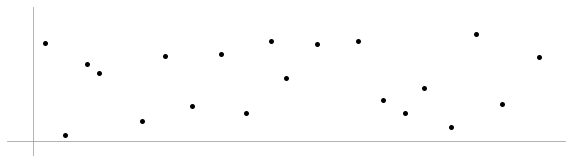

In [23]:
# plt.scatter(xs, ys)
plotFct(xs, ys)

Now, use `xipl = np.linspace(np.min(xs),np.max(xs),1000)` to create an array of interpolation points and use what you have previously learned about the scipy function `interp1d` to interpolate the above function $f$ as a function $\hat{f}$. Implement code that performs interpolation of discrete uni-variate functions and use **nearest neighbor** interpolation, **linear** interpolation and **cubic spline** interpolation to obtain three interpolated functions $\hat{f}$.

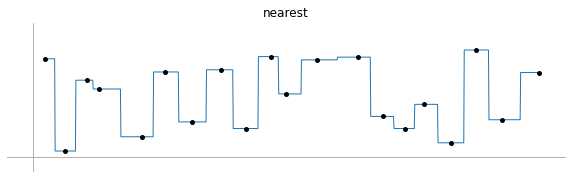

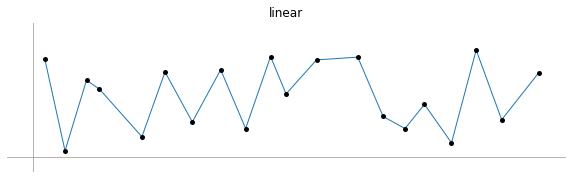

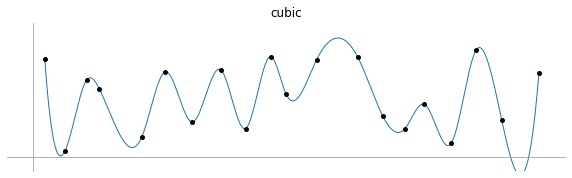

In [26]:
for kind in ['nearest', 'linear', 'cubic']:
    # Define an interpolation (function) of the data (xs, ys).
    fhat = ipl.interp1d(xs, ys, kind=kind)
    # Generate sample points for the evaluation.
    xipl = np.linspace(np.min(xs), np.max(xs), 1000)
    # Evaluate the interpolation at the sample points.
    yipl = fhat(xipl)

    plotFct(xs, ys, xipl, yipl, title=kind)

## 2 - Another kind of waves warp

Implement code that warps an input image into output images as if they were liquified and stretched in regular intervals in the horizontal and/or vertical direction.

For this, recall which mathematical function is featured prominently in this context. Which role could
the parameters **amplitude** $\alpha$, **frequency** $\nu$, and **phase** $\varphi$ play?

Run your code on the image `clock.jpg` and experiment with different
parametrizations.

In [39]:
def sinewarp(arrF, alpha_x, alpha_y, nu_x, nu_y, phi_x, phi_y):
    """
        Sinewarp implementation 1.
    """
    h, w = arrF.shape

    # Convert the phase angles from degrees to radians.
    phix = np.deg2rad(phi_x)
    phiy = np.deg2rad(phi_y)

    # Amplify the frequency if necessary w.r.t. image size.
    if np.abs(h*nu_x - np.pi) < 0.001:
        amplify_x = 1
    else:
        amplify_x = 2
        
    if np.abs(w*nu_y - np.pi) < 0.001:
        amplify_y = 1
    else:
        amplify_y = 2
    # Apply the amplification the get the final frequency
    nh, nw = h+amplify_y*alpha_y, w+amplify_x*alpha_x
    
    # Set up the data points.
    xs, ys = np.meshgrid(np.linspace(0,nw-1,nw), np.linspace(0,nh-1,nh))
    xs, ys = xs.flatten(), ys.flatten()

    # Apply the sinewarp.
    xs -= alpha_x
    ys -= alpha_y
    xs += alpha_x * np.sin(ys*nu_x - phi_x)
    ys += alpha_y * np.sin(xs*nu_y - phi_y)

    # Map the data to an image array.
    arrG = img.map_coordinates(arrF, np.vstack((ys,xs)))
    arrG = arrG.reshape(nh, nw)

    return arrG

In [41]:
def sinewarp(arrF, alpha_x, alpha_y, nu_x, nu_y, phi_x, phi_y):
    """
        Sinewarp implementation 2.
    """
    M, N = arrF.shape

    # Compute new image dimensions to match with the amplitude.
    newM = M + 2*alpha_y
    newN = N + 2*alpha_x
    
    # Convert the phase angles from degrees to radians.
    phix = np.deg2rad(phi_x)
    phiy = np.deg2rad(phi_y)

    # Set up the data points.
    xs, ys = np.meshgrid(np.linspace(0, newN-1, newN),
                         np.linspace(0, newM-1, newM))
    xs, ys = xs.flatten(), ys.flatten()

    # Apply the sinewarp.
    xs += alpha_x * np.sin(ys*nu_x - phi_x) - alpha_x
    ys += alpha_y * np.sin(xs*nu_y - phi_y) - alpha_y

    # Map the data to an image array.
    arrG = img.map_coordinates(arrF, np.vstack((ys,xs)))
    arrG = arrG.reshape(newM, newN)

    return arrG

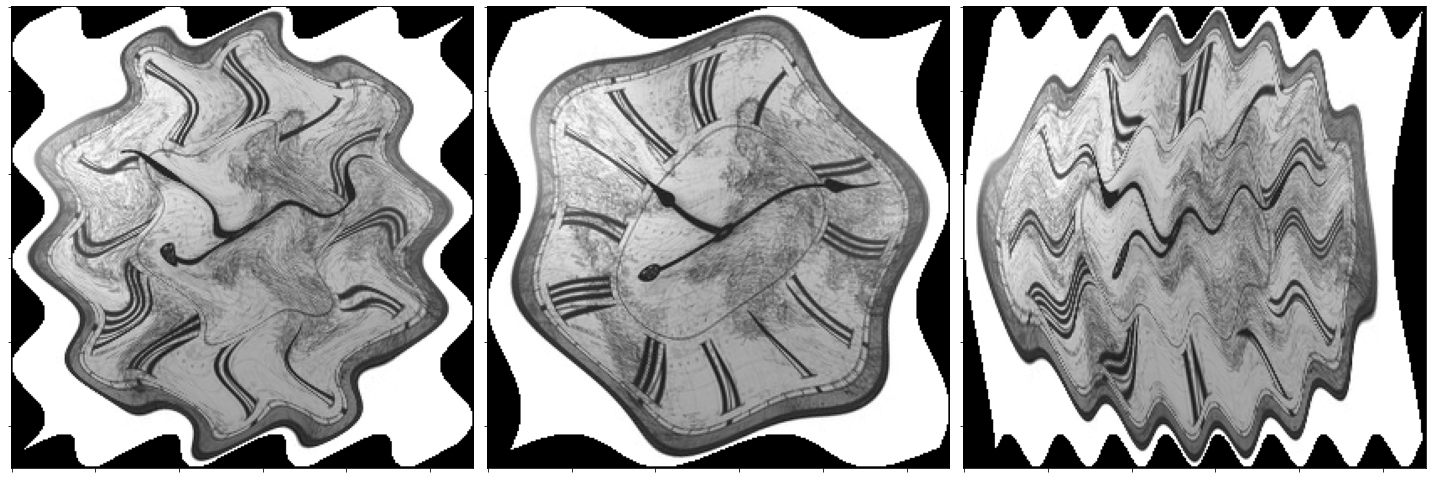

In [45]:
#arrF = imageRead('../exercise6/Data/clock.jpg')
arrF = imageRead('clock.jpg')
parameters = [(10, 10, 0.10, 0.10, 45, 0),
            (10, 10, 0.05, 0.05, 45, 0),
            (10, 10, 0.02, 0.20, 45, 0)]

fig, axs = plt.subplots(1, len(parameters), figsize=(20,20))

for i, params in enumerate(parameters):
    arrG = sinewarp(arrF, *params)
    arrG = imageClipRange(arrG)

    ax = axs[i]
    ax.imshow(arrG, cmap='gray') 
    ax.set_xticklabels([]); ax.set_yticklabels([])    

fig.tight_layout()
plt.show()

## 3 - Cylinder anamorphosis

Cylinder anamorphosis was a popular form of art in the 18th century where
images were drawn in a warped fashion. They would appear un-warped when viewed in a *cylindrical mirror*.

### a) Implement a program that can warp a rectangular image to radial discs.
### b) Extend the program such tath it can warp images onto a torus.

In [42]:
def anamorph(arrF, rmin=0.):
    # Reverse the order of elements along axis 0 (up/down).
    # For this 2-D array, this flips each column in the up/down direction.
    # Rows are preserved, but appear in a different order than before.
    fctF = np.flipud(arrF)
    h, w = fctF.shape

    # Calculate the diameter and radius of the disc/torus using the image dimensions.
    diam = int(np.sqrt(w**2 + h**2))
    rmax = diam / 2

    # Set up the data points.
    us, vs = np.meshgrid(np.arange(diam), np.arange(diam))
    us, vs = us.flatten() - rmax, vs.flatten() - rmax

    # Map the data point coordinates to the disc/torus polar coordinates.
    rs = np.sqrt(us**2 + vs**2)
    ps = np.arctan2(vs, -us); ps[ps<0] += 2*np.pi - 2*np.pi / h

    # Define the reverse mapping.
    xs = (rs-rmin) * h / (rmax-rmin)
    ys = ps * w / (2*np.pi)

    # Apply the coordinate warp on the intensity values of the image.
    fctG = img.map_coordinates(fctF, np.vstack((xs,ys)))
    fctG = fctG.reshape(diam, diam)

    return np.flipud(fctG)

Apply your extended implementation to the image `flower.png` and experiment with different parameter choices.

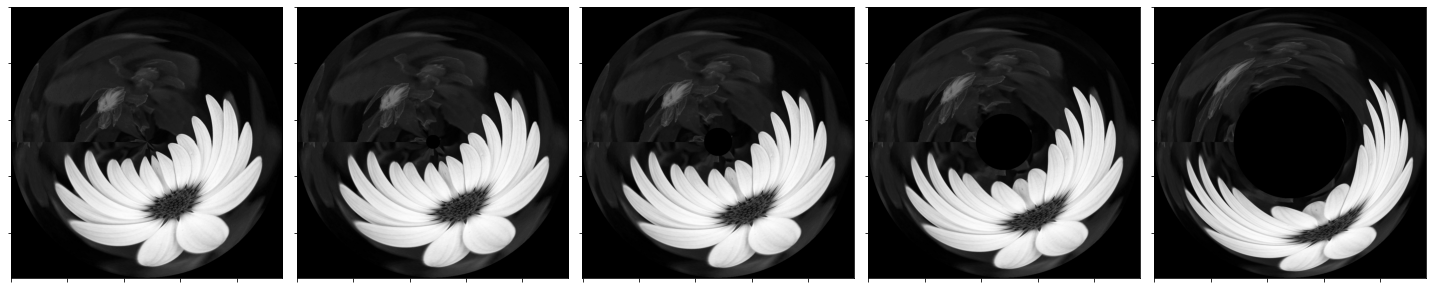

In [49]:
#arrF = imageRead('../exercise6/Data/flower.png')
arrF = imageRead('flower.png')
parameters = [0, 25, 50, 100, 200]

fig, axs = plt.subplots(1, len(parameters), figsize=(20,20))

for i, rmin in enumerate(parameters):
    arrG = anamorph(arrF, rmin)
    arrG = imageClipRange(arrG)

    ax = axs[i]
    ax.imshow(arrG, cmap='gray') 
    ax.set_xticklabels([]); ax.set_yticklabels([])    

fig.tight_layout()
plt.show()

## 4 - Radial blur

In one of our early lectures, we discussed the idea of representing an
image in $[r, \varphi]$ coordinates rather than in $[x, y]$ coordinates.
Later, we also saw, that interesting effects result from applying Gaussian
smoothing to this representation. In particular, if we transform from $[x, y]$ to $[r, \varphi]$ coordinates, apply a 1D Gaussian filter along the $\varphi$ dimension of the transformed image, and then transform the result back into $[x, y]$ coordinates, we obtain a circularly blurred image.

Implement a program that realizes this chain of processing steps. Apply
it to the image `clock.jpg` and experiment with different choices for the variance parameter of the Gaussian filter kernel.

In [57]:
def r_phi_blur(arrF, sigma=13.):
    # Determine the image dimensions and center point.
    M, N = arrF.shape
    cntr = np.array(arrF.shape) / 2
    
    # Compute the maximum radius value and the maximum phi value.
    rmax = np.sqrt(cntr[1]**2 + cntr[0]**2)
    pmax = 2 * np.pi

    # Transform the image into (r,phi) representation.
    rs, ps = np.meshgrid(np.linspace(0, rmax, N),
                         np.linspace(0, pmax, M))
    xs, ys = cntr[1] + rs * np.cos(ps), cntr[0] + rs * np.sin(ps)
    xs, ys = xs.flatten(), ys.flatten()

    arrG = img.map_coordinates(arrF, np.vstack((xs,ys)))
    arrG = arrG.reshape(M, N)
    
    # Apply angular smoothing.
    arrS = img.gaussian_filter1d(arrG, sigma=sigma, axis=0, mode='wrap')

    # Compute back transformations.
    us, vs = np.meshgrid(np.linspace(0, N-1, N),
                         np.linspace(0, M-1, M))
    us, vs = us.flatten() - cntr[1], vs.flatten() - cntr[0]


    rs = np.sqrt(us**2 + vs**2) / rmax * N 
    ps = np.arctan2(vs, us)
    ps[vs<0] += pmax * (1 - 1/M)
    ps = ps / pmax * M
    
    arrH = img.map_coordinates(arrS, np.vstack((ps,rs)))
    arrH = arrH.reshape(M, N)
    return arrH

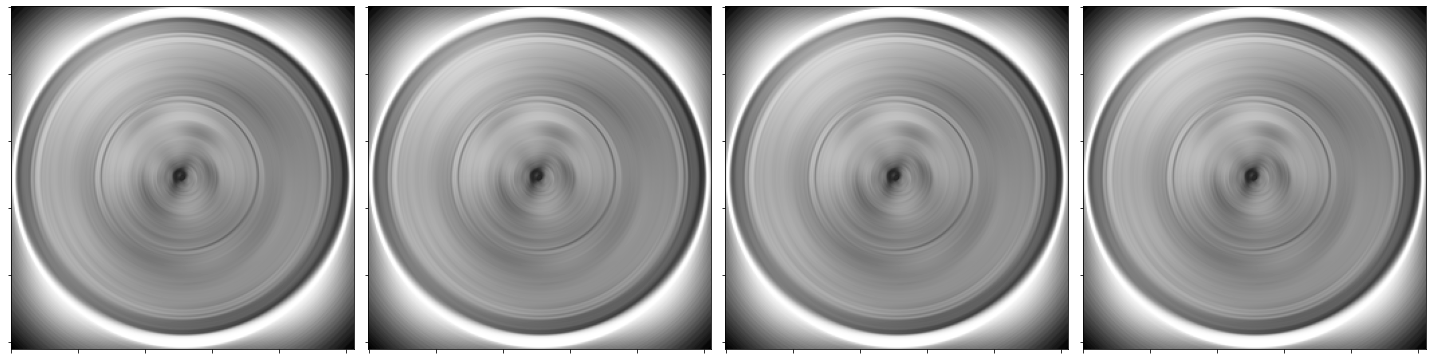

In [58]:
#arrF = imageRead('../exercise6/Data/clock.jpg')
arrF = imageRead('clock.jpg')
parameters = [2, 4, 8, 16]

fig, axs = plt.subplots(1, len(parameters), figsize=(20,20))

for i, rmin in enumerate(parameters):
    arrG = r_phi_blur(arrF)
    arrG = imageClipRange(arrG)

    ax = axs[i]
    ax.imshow(arrG, cmap='gray') 
    ax.set_xticklabels([]); ax.set_yticklabels([])    

fig.tight_layout()
plt.show()

## 5 - Augmented reality

In the lecture, we discussed perspective mappings between quadrilaterals to create simple augmented reality effects like projecting an image onto a wall which is part of an image itself.

Implement a program that maps the image `clock.jpg` onto the poster seen in the image `isle.jpg`. Assume that the four corners of the poster coincide with following $[u, v]$ array coordinates:

$$
u_{\text{ul}} = \begin{bmatrix} 215 \\ 56 \end{bmatrix}
\qquad u_{\text{ur}} = \begin{bmatrix} 365 \\ 10 \end{bmatrix}
\qquad u_{\text{ll}} = \begin{bmatrix} 218 \\ 258 \end{bmatrix}
\qquad u_{\text{lr}} = \begin{bmatrix}  364 \\ 296 \end{bmatrix}
$$

where we assume that the origin $[0,0]$ of the image `isle.jpg` is located in its upper left corner.

In [59]:
def computePerspectiveCoefficients(X, U): 
    M = np.array([[U[0,0], U[1,0], 1, 0, 0, 0, -U[0,0]*X[0,0], -U[1,0]*X[0,0]],
                  [U[0,1], U[1,1], 1, 0, 0, 0, -U[0,1]*X[0,1], -U[1,1]*X[0,1]],
                  [U[0,2], U[1,2], 1, 0, 0, 0, -U[0,2]*X[0,2], -U[1,2]*X[0,2]],
                  [U[0,3], U[1,3], 1, 0, 0, 0, -U[0,3]*X[0,3], -U[1,3]*X[0,3]],
                  [0, 0, 0, U[0,0], U[1,0], 1, -U[0,0]*X[1,0], -U[1,0]*X[1,0]],
                  [0, 0, 0, U[0,1], U[1,1], 1, -U[0,1]*X[1,1], -U[1,1]*X[1,1]],
                  [0, 0, 0, U[0,2], U[1,2], 1, -U[0,2]*X[1,2], -U[1,2]*X[1,2]],
                  [0, 0, 0, U[0,3], U[1,3], 1, -U[0,3]*X[1,3], -U[1,3]*X[1,3]]])

    return la.inv(M) @ np.hstack((X[0,:], X[1,:]))


def computePerspectiveMatrix(X, U): 
    coefs = computePerspectiveCoefficients(X, U)
    return np.hstack((coefs,1)).reshape(3,3)


def computePerspectiveTransform(matP, us, vs):
    vecUVW = np.vstack((us, vs, np.ones_like(us)))
    vecXYZ = matP @ vecUVW
    vecXYZ = vecXYZ / vecXYZ[2]

    return vecXYZ[0], vecXYZ[1]

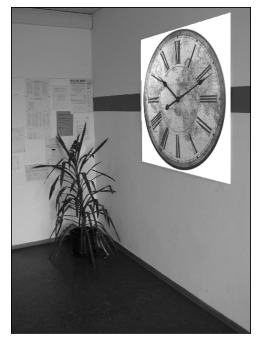

In [67]:
# scene = imageRead('../exercise6/Data/isle.jpg')
# inset = imageRead('../exercise6/Data/clock.jpg')
scene = imageRead('isle.jpg')
inset = imageRead('clock.jpg')

M, N = scene.shape
m, n = inset.shape

# Define the corners (u,v-coordinates) of the poster in the scene image.
matU = np.vstack((np.array([215, 365, 364, 218]),
                  np.array([ 56,  10, 296, 258])))

# Define the corners (x,y-coordinates) of the inset image.
matX = np.vstack((np.array([0, n-1, n-1, 0]),
                    np.array([0, 0, m-1, m-1])))

# Define a perspective projection matrix P to map (u,v) onto (x,y).
matP = computePerspectiveMatrix(matX, matU)

# The new image has the same size as the scene image.
us, vs = np.meshgrid(np.linspace(0,N-1,N), np.linspace(0,M-1,M))

# Apply the perspective mappint P.
xs, ys = computePerspectiveTransform(matP, us.flatten(), vs.flatten())

# Pull the image intensities from the inset image into the new image.
iwarp = img.map_coordinates(inset, np.vstack((ys,xs)), order=3, cval=-1)
iwarp = iwarp.reshape(M,N)
smask = iwarp==-1

result = imageClipRange(iwarp)
result[smask] = scene[smask]

# Plot the result.
plt.imshow(result, cmap="gray")
plt.xticks([]); plt.yticks([]);